In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from config import TRAIN_DIR, DATASET_DIR
sns.set_style('darkgrid')

Reading dataset

In [2]:
df = pd.read_csv(DATASET_DIR)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


Create a dataset that will store the unique names of images and the number of ships on them

In [4]:
df['Ships'] = df['EncodedPixels'].apply(lambda row: 1 if isinstance(row, str) else 0)
grouped_df = df.groupby('ImageId').agg({'Ships': 'sum'}).reset_index()
grouped_df

,ImageId,Ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


In [5]:
print('Number of images that have ships:',
      np.round(len(grouped_df[grouped_df['Ships'] > 0]) / len(grouped_df) * 100, 2), '%.')

Number of images that have ships: 22.1 %.


In [6]:
grouped_df['Ships'].value_counts()

Ships
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

Text(0.5, 1.0, 'Count of images relative to the number of ships on them')

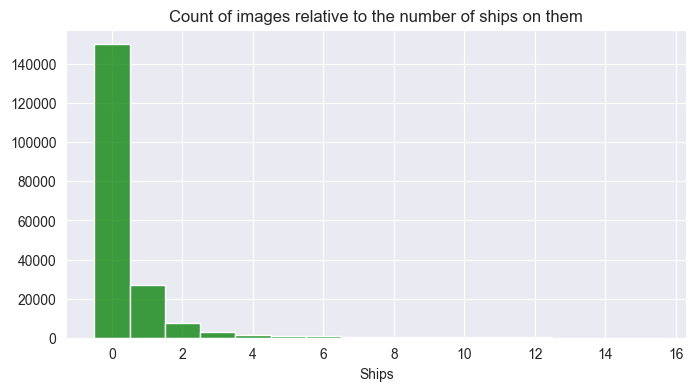

In [7]:
plt.figure(figsize=(8, 4))
sns.histplot(grouped_df['Ships'], discrete=True, color='green')
plt.ylabel(None)
plt.title('Count of images relative to the number of ships on them')

Text(0.5, 1.0, 'Count of images relative to the number of ships on them \n(bigger than 1 ship on the image)')

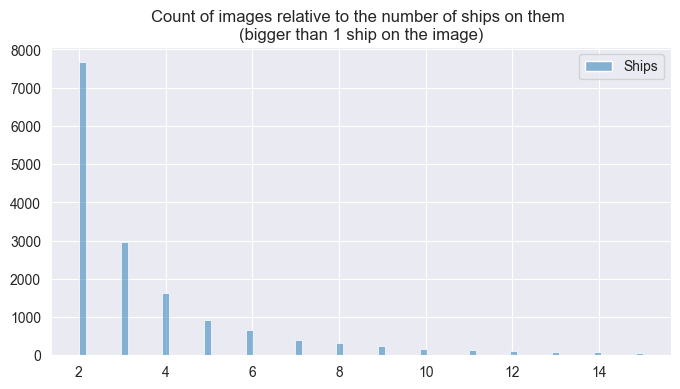

In [8]:
plt.figure(figsize=(8, 4))
sns.histplot(grouped_df[grouped_df['Ships'] > 1], discrete=True)
plt.ylabel(None)
plt.title('Count of images relative to the number of ships on them \n(bigger than 1 ship on the image)')

The **dataset is not balanced**, so it is worth selecting a certain number of images of each group (group == number of ships in the image) for training sampling.

The number to be sampled is written in the config file. By default it is equal to 4000.

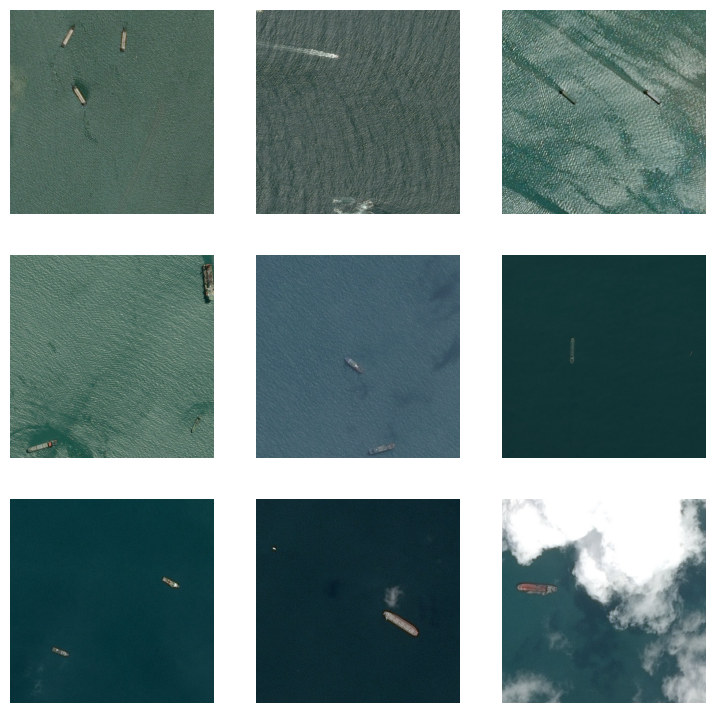

In [9]:
from PIL import Image
plt.figure(figsize=(9,9))
for i in range(9):
    image = Image.open(TRAIN_DIR + grouped_df.sample(1)['ImageId'].iloc[0])
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

The images include other objects besides **water** and **ships**: shores, sand, islands, cities, towns, land areas, and so on...

The presence of images with extraneous objects will affect the accuracy of future model performance

Let's see how the masks are presented:

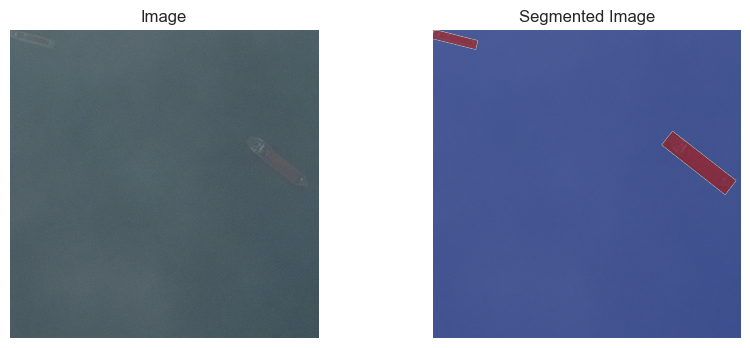

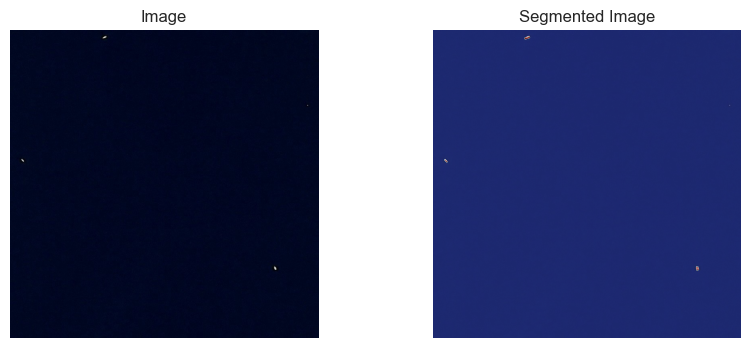

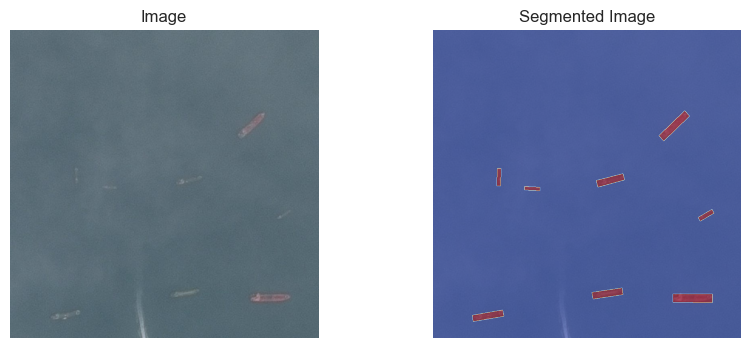

In [10]:
rows = 1
columns = 2

grouped_df = pd.DataFrame(df.groupby('ImageId')['EncodedPixels'].apply(
    lambda x: None if type(x.values[0]) == float else ' '.join(x.astype(str))))

for _ in range(3):
    sample_row = grouped_df.loc[grouped_df.EncodedPixels.notnull()].sample(1)

    image = Image.open((TRAIN_DIR + sample_row.index[0]))

    seg_img = np.zeros((image.size[0] * image.size[1]))

    RLE = [int(x) for x in sample_row['EncodedPixels'].values[0].split(' ')]
    for idx in range(0, len(RLE), 2):
        seg_img[RLE[idx] : RLE[idx] + RLE[idx + 1]] = 1
    seg_img = np.transpose(np.reshape(seg_img, (image.size[0], image.size[1], 1)), (1,0,2))

    fig = plt.figure(figsize=(10, 4))

    # Plot the original image
    fig.add_subplot(rows, columns, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image")

    # Plot the segmentation
    fig.add_subplot(rows, columns, 2)
    plt.imshow(image)
    plt.imshow(seg_img, cmap='coolwarm', alpha=0.5)
    plt.axis('off')
    plt.title("Segmented Image")

**Results**:
- the dataset is unbalanced
- the number of ships in the photos varies from 0 to 15
- dataset has satellite images with extraneous objects in them